In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
reddit_counts = pd.read_json('reddit-counts.json.gz', lines=True)

In [3]:
counts = reddit_counts.copy()

In [4]:
counts.dtypes

date             datetime64[ns]
subreddit                object
comment_count             int64
dtype: object

In [5]:
# filter values in 2012 and 2013
counts = counts[(counts['date'] >= '2012-01-01') & (counts['date'] <'2014-01-01')]
# filter values in the /r/canada subreddit
counts = counts[counts['subreddit'] == 'canada']
# reset index and drop index col
counts = counts.reset_index()
counts = counts.drop(columns='index')
# assign weekday values to dates
fil_counts = counts.copy()
fil_counts['weekday'] = fil_counts['date'].dt.dayofweek
fil_counts

,date,subreddit,comment_count,weekday
0,2013-03-14,canada,1657,3
1,2013-07-08,canada,1369,0
2,2012-07-04,canada,1343,2
3,2013-03-11,canada,1619,0
4,2013-09-11,canada,1909,2
...,...,...,...,...
726,2013-01-01,canada,2113,1
727,2013-07-27,canada,1070,5
728,2012-10-19,canada,1486,4
729,2012-01-15,canada,1256,6


In [6]:
# seperate weekends in a seperate df
weekends = fil_counts[fil_counts['weekday'] >= 5] 
weekends

,date,subreddit,comment_count,weekday
5,2012-02-04,canada,1196,5
9,2012-11-17,canada,1570,5
17,2013-07-14,canada,908,6
21,2013-06-22,canada,984,5
22,2012-07-29,canada,1199,6
...,...,...,...,...
717,2012-11-04,canada,1772,6
721,2012-12-09,canada,1350,6
722,2012-12-02,canada,1725,6
727,2013-07-27,canada,1070,5


In [7]:
# seperate weekdays in a seperate df
weekdays = fil_counts[fil_counts['weekday'] <= 4] 
weekdays

,date,subreddit,comment_count,weekday
0,2013-03-14,canada,1657,3
1,2013-07-08,canada,1369,0
2,2012-07-04,canada,1343,2
3,2013-03-11,canada,1619,0
4,2013-09-11,canada,1909,2
...,...,...,...,...
724,2013-04-10,canada,2021,2
725,2013-03-19,canada,1630,1
726,2013-01-01,canada,2113,1
728,2012-10-19,canada,1486,4


##### Student's T-Test

In [8]:
# do a T-test on the data to get a p-value
stats.ttest_ind(weekdays['comment_count'], weekends['comment_count']).pvalue

1.3005502847207912e-58

In [9]:
# try normality test to see if the data is normally-distributed
stats.normaltest(weekdays['comment_count']).pvalue

1.0091137251707994e-07

In [10]:
# try normality test to see if the data is normally-distributed
stats.normaltest(weekends['comment_count']).pvalue

0.0015209196859635404

In [11]:
# check if the two data sets have equal variances
stats.levene(weekdays['comment_count'], weekends['comment_count']).pvalue

0.04378740989202803

##### Fix 1: transforming data might save us

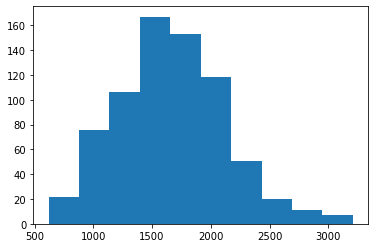

In [12]:
plt.hist(fil_counts['comment_count']);

In [13]:
fil_counts

,date,subreddit,comment_count,weekday
0,2013-03-14,canada,1657,3
1,2013-07-08,canada,1369,0
2,2012-07-04,canada,1343,2
3,2013-03-11,canada,1619,0
4,2013-09-11,canada,1909,2
...,...,...,...,...
726,2013-01-01,canada,2113,1
727,2013-07-27,canada,1070,5
728,2012-10-19,canada,1486,4
729,2012-01-15,canada,1256,6


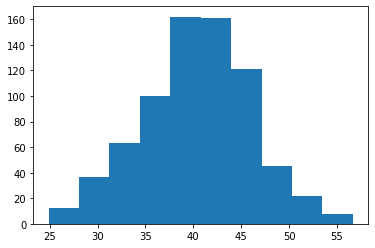

In [14]:
# skewed: transform data
t_counts = fil_counts.copy()
t_counts['comment_count'] = np.sqrt(t_counts['comment_count'])
plt.hist(t_counts['comment_count']);

In [15]:
t_weekends = t_counts[t_counts['weekday'] >= 5] 
t_weekends

,date,subreddit,comment_count,weekday
5,2012-02-04,canada,34.583233,5
9,2012-11-17,canada,39.623226,5
17,2013-07-14,canada,30.133038,6
21,2013-06-22,canada,31.368774,5
22,2012-07-29,canada,34.626579,6
...,...,...,...,...
717,2012-11-04,canada,42.095130,6
721,2012-12-09,canada,36.742346,6
722,2012-12-02,canada,41.533119,6
727,2013-07-27,canada,32.710854,5


In [16]:
t_weekdays = t_counts[t_counts['weekday'] <= 4] 
t_weekdays

,date,subreddit,comment_count,weekday
0,2013-03-14,canada,40.706265,3
1,2013-07-08,canada,37.000000,0
2,2012-07-04,canada,36.646964,2
3,2013-03-11,canada,40.236799,0
4,2013-09-11,canada,43.692105,2
...,...,...,...,...
724,2013-04-10,canada,44.955534,2
725,2013-03-19,canada,40.373258,1
726,2013-01-01,canada,45.967380,1
728,2012-10-19,canada,38.548671,4


In [17]:
# try normality test to see if the transformed data is normally-distributed
stats.normaltest(t_weekends['comment_count']).pvalue, stats.normaltest(t_weekdays['comment_count']).pvalue

(0.10760562894666933, 0.03687221613365365)

In [18]:
# check if the transformed data sets have equal variances
stats.levene(t_weekdays['comment_count'], t_weekends['comment_count']).pvalue

0.5560544297516696

##### Fix 2: the Central Limit Theorem might save us.

In [19]:
# combine all weekdays and weekend days from each year/week pair and take the mean of their (non-transformed) counts
f_counts = counts.copy()
f_counts[['year', 'week', 'day']] = f_counts['date'].dt.isocalendar()
f_counts

,date,subreddit,comment_count,year,week,day
0,2013-03-14,canada,1657,2013,11,4
1,2013-07-08,canada,1369,2013,28,1
2,2012-07-04,canada,1343,2012,27,3
3,2013-03-11,canada,1619,2013,11,1
4,2013-09-11,canada,1909,2013,37,3
...,...,...,...,...,...,...
726,2013-01-01,canada,2113,2013,1,2
727,2013-07-27,canada,1070,2013,30,6
728,2012-10-19,canada,1486,2012,42,5
729,2012-01-15,canada,1256,2012,2,7


In [20]:
f_weekends = f_counts[f_counts['day'] >= 6]
f_weekends = f_weekends.groupby(by=['year', 'week']).aggregate('mean')
f_weekends = f_weekends.drop(f_weekends.index[0])
f_weekends

comment_count  day
year week                    
2012 1            1163.0  6.5
     2            1372.0  6.5
     3             915.5  6.5
     4            1285.0  6.5
     5            1228.0  6.5
...                  ...  ...
2013 48           1553.0  6.5
     49           1412.5  6.5
     50           1547.0  6.5
     51           1173.5  6.5
     52           1117.5  6.5

[104 rows x 2 columns]

In [1]:
f_weekdays = f_counts[f_counts['day'] < 6]
f_weekdays = f_weekdays.groupby(by=['year', 'week']).aggregate('mean')
f_weekdays = f_weekdays.drop(f_weekdays.index[-1])


NameError: name 'f_counts' is not defined

In [22]:
# now, try normality test to see if the data is normally-distributed
stats.normaltest(f_weekends['comment_count']).pvalue

0.1717955067860438

In [23]:
# now, try normality test to see if the data is normally-distributed
stats.normaltest(f_weekdays['comment_count']).pvalue

0.32667705109275175

In [24]:
# now, check if the transformed data sets have equal variances
stats.levene(f_weekdays['comment_count'], f_weekends['comment_count']).pvalue

0.18667103349089625

In [25]:
# perform a T-test on the data to get a p-value
stats.ttest_ind(f_weekdays['comment_count'], f_weekends['comment_count']).pvalue

1.6858630842787966e-34

##### Fix 3: a non-parametric test might save us.

In [26]:
# perform a U-test on the (original non-transformed, non-aggregated) counts
# note: do a two-sided test 
stats.mannwhitneyu(weekdays['comment_count'], weekends['comment_count']).statistic

93999.0

In [28]:
np.sum(f_weekdays['comment_count'])

189806.8

In [29]:
np.sum(f_weekends['comment_count'])

132166.0